Convert the raw weather data from Big Query to Structured CSV file

In [1]:
import pandas as pd
import json
import re

def correct_to_json_format(text):
    """Correct formatting of text to JSON-compatible strings."""
    if pd.isnull(text):
        return "{}"
    text = re.sub(r"([a-zA-Z_]+):", r'"\1":', text)
    text = text.replace("'", '"')
    return text

def parse_nested_weather(text):
    """Parse nested weather data into a dictionary."""
    try:
        return json.loads(correct_to_json_format(text).strip("[]"))
    except Exception:
        return {}

def parse_columns(input_csv, output_csv):
    """Parse 'main' and 'wind' columns and save to a new CSV."""

    df = pd.read_csv(input_csv)

    df["main_corrected"] = df["main"].apply(correct_to_json_format)
    main_cleaned = df["main_corrected"].apply(json.loads).apply(pd.Series)

    df["wind_corrected"] = df["wind"].apply(correct_to_json_format)
    wind_cleaned = df["wind_corrected"].apply(parse_nested_weather).apply(pd.Series)

    structured_df = pd.concat([df[["timestamp"]], main_cleaned, wind_cleaned], axis=1)

    structured_df.to_csv(output_csv, index=False)
    print(f"Parsed data saved to {output_csv}")


input_csv = "weather_data.csv"
output_csv = "structured_weather_data.csv"
parse_columns(input_csv, output_csv)


Parsed data saved to structured_weather_data.csv


remove unwante columns from the weather

In [2]:
input_csv  = "structured_weather_data.csv"
output_csv = "structured_weather_data.csv"

df = pd.read_csv(input_csv)

# Remove unwanted columns
columns_to_remove = ['gust', 'temp_min', 'temp_max', 'pressure', 'grnd_level', 'sea_level', 'deg']
df.drop(columns=[col for col in columns_to_remove if col in df.columns], inplace=True)
df.rename(columns={'speed': 'wind_speed'}, inplace=True)

df.to_csv(output_csv, index=False)
print(f"Cleaned CSV saved to {output_csv}")


Cleaned CSV saved to structured_weather_data.csv


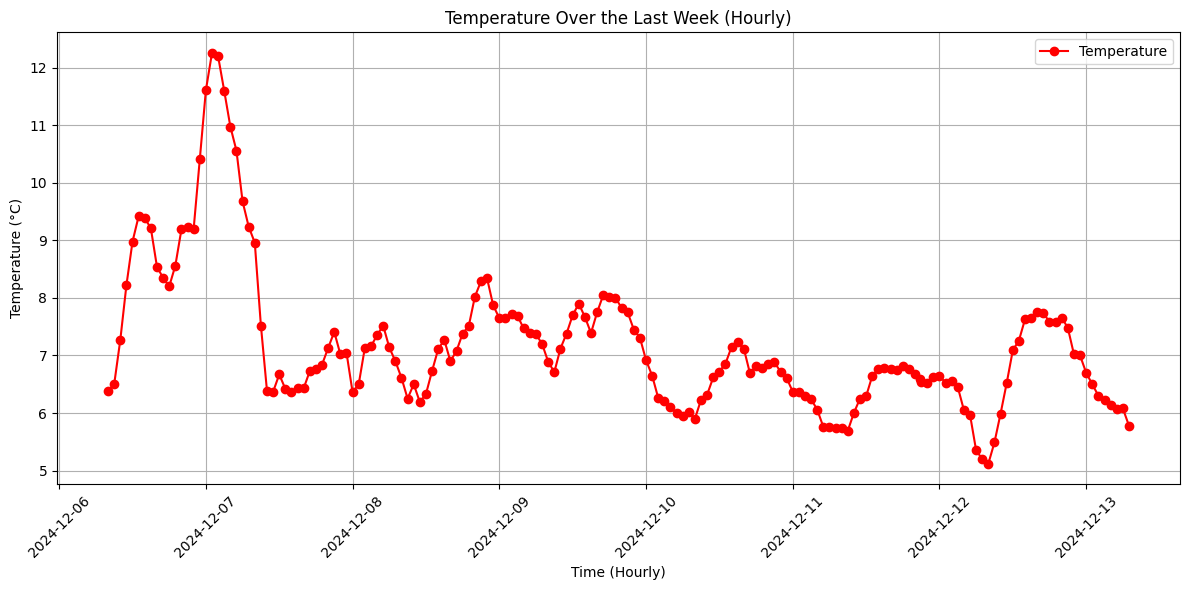

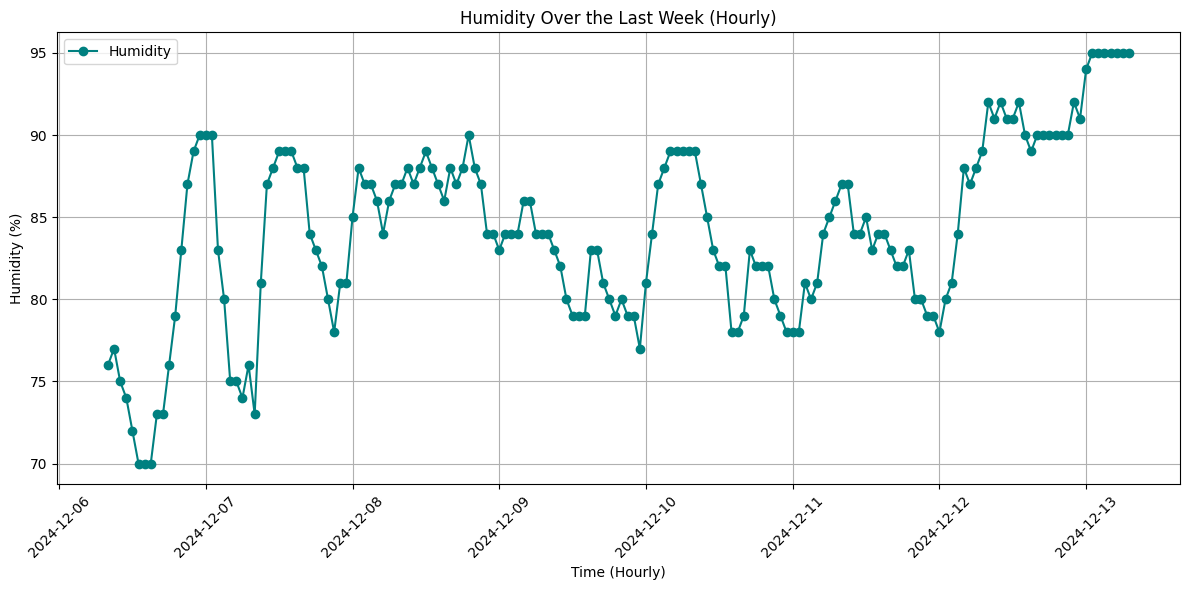

In [27]:
import pandas as pd
import matplotlib.pyplot as plt


file_path = "structured_weather_data.csv"  # Replace with your uploaded file path
data = pd.read_csv(file_path)

# Convert timestamp to datetime for better handling
data['timestamp'] = pd.to_datetime(data['timestamp'], format='%Y%m%d_%H%M')

# Extract the relevant data for plotting
temperature_column = 'temp'
humidity_column = 'humidity'
last_week_data = data[['timestamp', temperature_column, humidity_column]].dropna()

# Temperature Plot
plt.figure(figsize=(12, 6))
plt.plot(last_week_data['timestamp'], last_week_data[temperature_column], marker='o', linestyle='-', color='red', label='Temperature')
plt.xlabel('Time (Hourly)')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Over the Last Week (Hourly)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Humidity Plot
plt.figure(figsize=(12, 6))
plt.plot(last_week_data['timestamp'], last_week_data[humidity_column], marker='o', linestyle='-', color='teal', label='Humidity')
plt.xlabel('Time (Hourly)')
plt.ylabel('Humidity (%)')
plt.title('Humidity Over the Last Week (Hourly)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


We imported the csv files from the cloud withour time stamps and now just take the first hour to be previous hour and just remove last column thats it to rearrange the timestamps.

Combine the csv files

In [17]:
import pandas as pd

file1 = "sse_stock_data.csv"
file2 = "aviva_stock_data.csv"
file3 = "tesco_stock_data.csv"
file4 = "structured_weather_data.csv"

df = pd.read_csv(file4)

df1 = pd.read_csv(file1)

df1.drop(columns=['high_price', 'low_price', 'close_price'], inplace=True)
df1.rename(columns={'open_price': 'SSE open'}, inplace=True)
df1.rename(columns={'volume': 'SSE volume'}, inplace=True)

df2 = pd.read_csv(file2)
df2.drop(columns=['high_price', 'low_price', 'close_price'], inplace=True)
df2.rename(columns={'open_price': 'AV open price'}, inplace=True)
df2.rename(columns={'volume': 'AV volume'}, inplace=True)

df3 = pd.read_csv(file3)
df3.drop(columns=['high_price', 'low_price', 'close_price'], inplace=True)
df3.rename(columns={'open_price': 'TSCO open price'}, inplace=True)
df3.rename(columns={'volume': 'TSCO volume'}, inplace=True)

df4 = pd.read_csv(file4)


# Concatenate the data side by side
combined_df = pd.concat([df4, df1, df2, df3], axis=1)


output_file = "combined_data.csv"
combined_df.to_csv(output_file, index=False)

print(f"Combined data saved to {output_file}")


Combined data saved to combined_data.csv


remove the the repeated values of stocks on weekends and non-trading hours values

In [20]:
import pandas as pd

def remove_repeated_rows_dynamic(input_file, output_file, columns):

    df = pd.read_csv(input_file)

    # Track the previous row values
    previous_values = None
    start_idx = None
    rows_to_drop = []

    for idx, row in df.iterrows():
        current_values = tuple(row[columns])  # Get current row values for the specified columns

        if current_values == previous_values:  # Repeating section detected
            if start_idx is None:
                start_idx = idx - 1  # Mark the start of the repeating range
            rows_to_drop.append(idx)  # Add row to drop list
        else:
            start_idx = None  # Reset start index when repeating ends

        previous_values = current_values  # Update previous values

    # Drop the rows from the DataFrame
    deduplicated_df = df.drop(rows_to_drop)

    # Save the resulting dataframe to a new CSV file
    deduplicated_df.to_csv(output_file, index=False)
    print(f"Processed data saved to {output_file}")

# Example usage
input_file = "combined_data.csv"  # Replace with your input CSV file name
output_file = "weather_stock_analysis_data.csv"  # Replace with your desired output file name
columns_to_consider = ['SSE open', 'AV open price', 'TSCO open price', ]  # Replace with the column names to check for duplicates

remove_repeated_rows_dynamic(input_file, output_file, columns_to_consider)

Processed data saved to weather_stock_analysis_data.csv


Finally Changing the time stamps for visualisation

In [23]:
import pandas as pd

# Load the CSV file (replace 'your_file.csv' with the actual file path)

df = pd.read_csv('/content/weather_stock_analysis_data.csv')

# Rename columns to match their values (you can adjust these if needed)
df.columns = [
    "timestamp", "temp",	"humidity", "feels_like", "wind_speed",
    "SSE open",	"SSE volume",	"AV open price",	"AV volume",	"TSCO open price",	"TSCO volume"
]

# Parse the Raw_Date into separate Date and Time columns
df['Date'] = df['timestamp'].str[:8]  # First 8 characters for the date (e.g., "20241206")
df['Time'] = df['timestamp'].str[9:]  # Remaining characters for the time (e.g., "0900")

# Convert to a standard datetime format
df['Timestamp'] = pd.to_datetime(
    df['Date'] + ' ' + df['Time'].str[:2] + ':' + df['Time'].str[2:],
    format='%Y%m%d %H:%M'
)

# Drop the raw columns if no longer needed
df = df.drop(columns=["timestamp", "Date", "Time"])

# Reorder columns to make Timestamp the first column
df = df[["Timestamp",  "temp",	"humidity",
    "SSE open",	"SSE volume",	"AV open price",	"AV volume",	"TSCO open price",	"TSCO volume"]]

# Filter rows to include only trading hours (8:00 AM to 4:30 PM)
df = df[(df['Timestamp'].dt.hour >= 8) & (df['Timestamp'].dt.hour <= 16)]

# Save the cleaned dataset to a new CSV file
output_file = 'weather_stock_analysis_data.csv'
df.to_csv(output_file, index=False)

print(f"Cleaned dataset saved to {output_file}")


Cleaned dataset saved to weather_stock_analysis_data.csv
